 ## RNN Equations

1. Predict State

$$ H_t = \phi(X_t W_{xh} + H_{t-1} W_{hh} + b_h) $$

2. Predict Output from State

$$ O_t = H_t W_{hy} + b_y $$

## Points
* The state, H changes for every step

* The weight matrix is always same across time steps during prediction -> drastic parameter reduction

* 3 W, 2 b are the GD updateable parameters
* Inputs is usually 3D -> num_examples, time_steps, dimension
* dimension above is 1 -> univariate

* At any step t, computations are:
    1. concatenate $X_t, H_{t_1}$
    2. feed this to FC layer with weights $ W_{xh}, W_{hh}$ -> perform activation
    3. feed this to another FC output layer -> $O_t$
     

## Backward Prop

Assumption is you have 100 number of sin curve steps of 50 each where at the end you predict a single output (next time step).

1. $ L (MSE) = 0.5 * (y - y_{true})^2 $

2. $ \frac{\partial L}{\partial y} = (y - y_{true}) $

3. Wyh : 
    * $ \frac{\partial L}{\partial Wyh} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial Wyh} $

    * $ \frac{\partial L}{\partial Wyh} = (y - y_{true})*H_t $

4. by : 
    * $ \frac{\partial L}{\partial by} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial by} $

    * $ \frac{\partial L}{\partial by} = (y - y_{true}) $

5. Whh : 
    * $ \frac{\partial L}{\partial Whh} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial ht} \frac{\partial ht}{\partial Whh} $

    * $ \frac{\partial L}{\partial Whh} = (y - y_{true}) * Wyh * \sum (1 - H_t^2) * H_{t-1} $

6. Wxh : 
    * $ \frac{\partial L}{\partial Wxh} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial ht} \frac{\partial ht}{\partial Wxh} $

    * $ \frac{\partial L}{\partial Wxh} = (y - y_{true}) * Wyh * \sum (1 - H_t^2) * x_t $

7. bh : 
    * $ \frac{\partial L}{\partial bh} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial ht} \frac{\partial ht}{\partial bh} $

    * $ \frac{\partial L}{\partial bh} = (y - y_{true}) * Wyh * \sum (1 - H_t^2) $

8. $h_{t-1}$ : 
    * $ \frac{\partial L}{\partial h_{t-1}} = \frac{\partial L}{\partial y} \frac{\partial y}{\partial ht} \frac{\partial ht}{\partial h_{t-1}} $

    * $ \frac{\partial L}{\partial h_{t-1}} = (y - y_{true}) * Wyh * \sum (1 - H_t^2) * Whh $
    
        
 

## Dimensions

### State Prediction Step
* $X_t$ = n * d (number of minibatch, input_size)

* $W_{xh}$ = d * h (input_size, hidden_state_size)
* $H_t$ = n * h (number of minibatch, hidden_state_size)

* $W_{hh}$ = h * h (hidden_state_size, hidden_state_size)
* $b_h$ = 1 * h (hidden_state_size) 


### Output Prediction Step
* $W_{yh}$ = h * q (hidden_state_size, output_size)
* $b_y$ = 1 * q  (output_size) 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

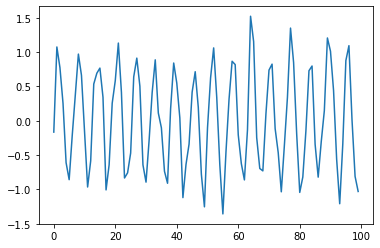

In [2]:
sin_wave = np.array([np.sin(x) for x in np.arange(200)]) + np.random.randn(200)*0.25
plt.plot(sin_wave[:100])

In [3]:

## Prepare data
X, Y = [], []

seq_len = 50
num_records = len(sin_wave) - seq_len 

for i in range(num_records - 50): # setting aside last 50 for validation
    X.append(sin_wave[i : i + seq_len])
    Y.append(sin_wave[i + seq_len])

X = np.array(X) # shape : num_record, seq_length
X = np.expand_dims(X, axis = 2) # Creating 3D input

Y = np.array(Y) # shape : num_record, seq_length
Y = np.expand_dims(Y, axis = 1) # Creating 2D output
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [4]:
import numpy as np
from numpy.random import randn

class RNN:

  # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = randn(hidden_size, hidden_size) / 1000
        self.Wxh = randn(hidden_size, input_size) / 1000
        self.Why = randn(output_size, hidden_size) / 1000

        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1))

        self.last_inputs = inputs
        self.last_hs = { 0: h }

        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            new_input = np.zeros(inputs.shape)
            new_input[i] = inputs[i]

            # print(self.Wxh.shape, x.shape, self.Whh.shape, h.shape)
            # np.dot(self.Wxh, x)
            h = np.tanh(self.Wxh @ new_input + self.Whh @ h + self.bh)
            self.last_hs[i + 1] = h

        # Compute the output
        y = self.Why @ h + self.by

        return y, h

    def backprop(self, d_y, learn_rate=2e-2):
        '''
        Perform a backward pass of the RNN.
        - d_y (dL/dy) has shape (output_size, 1).
        - learn_rate is a float.
        '''
        n = len(self.last_inputs)

        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.last_hs[n].T
        d_by = d_y

        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        # Calculate dL/dh for the last h.
        d_h = self.Why.T @ d_y

        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            temp = ((1 - self.last_hs[t + 1] ** 2) * d_h)

            # dL/db = dL/dh * (1 - h^2)
            d_bh += temp

            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += temp @ self.last_hs[t].T

            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += temp @ self.last_inputs.T

            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ temp

            # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)

        # Update weights and biases using gradient descent.
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

In [5]:
rnn = RNN(50, 1)
# Training loop
for epoch in range(10):
    loss = 0
    for i in range(len(Y)):
        x, y = X[i], Y[i]
        target = int(y)

        # Forward
        out, _ = rnn.forward(x)
        
        # Calculate loss / accuracy
        loss += (out - y)**2/2
        
        # Build dL/dy
        d_L_d_y = (out - y)
            
        # Backward
        rnn.backprop(d_L_d_y)
    
    loss = loss/float(Y.shape[0])
    print(f'Epoch {epoch} Loss {loss[0][0]}')

Epoch 0 Loss 0.30361359483376743
Epoch 1 Loss 0.30345204264689113
Epoch 2 Loss 0.30334388845131
Epoch 3 Loss 0.3030663104383355
Epoch 4 Loss 0.3022134038447083
Epoch 5 Loss 0.2996175688522975
Epoch 6 Loss 0.29219976918606927
Epoch 7 Loss 0.27303915959925074
Epoch 8 Loss 0.1868559253295143
Epoch 9 Loss 0.04441347954895135


In [6]:
prediction = []
for i in range(len(Y)):
    x, y = X[i], Y[i]
    # Forward
    pred, _ = rnn.forward(x)
    prediction.append(pred)
prediction = np.array(prediction)
prediction.shape, Y.shape

((100, 1, 1), (100, 1))

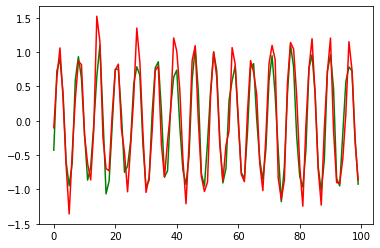

In [7]:
plt.plot(prediction[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()